<a href="https://colab.research.google.com/github/keehyun2/TestPy/blob/master/colab/8-2-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## 패션 MNIST 데이터 불러오기

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
print(train_input[0,14]) # 첫번째 이미지( index 0 )의 15 번째 행 (index 14) 의 픽셀 밝기를 출력 (최대 255)

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
print(train_scaled[0,14]) # reshpae 이후에 value 값이 1 개의 원소를 가진 array 로 바뀜

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

[  0   0   1   4   6   7   2   0   0   0   0   0 237 226 217 223 222 219
 222 221 216 223 229 215 218 255  77   0]
[[0.        ]
 [0.        ]
 [0.00392157]
 [0.01568627]
 [0.02352941]
 [0.02745098]
 [0.00784314]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.92941176]
 [0.88627451]
 [0.85098039]
 [0.8745098 ]
 [0.87058824]
 [0.85882353]
 [0.87058824]
 [0.86666667]
 [0.84705882]
 [0.8745098 ]
 [0.89803922]
 [0.84313725]
 [0.85490196]
 [1.        ]
 [0.30196078]
 [0.        ]]


In [ ]:
# reshape 를 통해서 채널 데이터(gray scale) 을 배열로 만듬.
# 입력 이미지를 CNN이 요구하는 4차원 텐서 형태로 변환 (배치 크기, 높이, 너비, 채널)
print(train_input.shape)
print(train_input.reshape(-1, 28, 28, 1).shape)
print(train_input.reshape(60000, 28, 28, 1).shape)
print(train_input.reshape(-1, 28 * 28).shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000, 28, 28, 1)
(60000, 784)


## 합성곱 신경망 만들기

In [ ]:
model = keras.Sequential()

In [ ]:
# 32 개의 특성, 커널사이즈 3 (3*3), 활성화함수 relu, padding 은 same (output 특성맵 의 크기(높이,너비)를 input(높이,너비) 과 동일하게만듬)
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
# 파라미터 수 = (필터 높이 × 필터 너비 × 입력 채널 수 × 필터 개수) + 편향(bias)
# 가중치(params) 는 320(3*3*1*32 + 32) 개 가 계산되고 output 은 (None, 28, 28, 32) 가 나옴. none 은 배치크기(이미지 개수).

In [ ]:
# 이전 층에서 나온 output 특성맵(28,28)을 2*2 의 영역마다 최대 값을 가져와서 새로운 특성맵(14,14) 를 만듬. 특성맵의 크기가 1/2 로 줄어듬
model.add(keras.layers.MaxPooling2D(2))
# (None, 14, 14, 32)

In [ ]:
# 위에 나온 conv2d 랑 동일하고 특성 개수만 64개로 다름.
# 파라미터 수 = (필터 높이 × 필터 너비 × 입력 채널 수 × 필터 개수) + 편향(bias)
# 3*3*32*64 + 64
# 가중치 는 18496 개가 계산됨. 각 샘플 이미지(1개) 별로 나온 특성맵이미지 32 개를 64개의 특성맵으로 또 분석, 가중치가 엄청 많아짐..
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
# (None, 14, 14, 64)
# 특성맵을 1/2 로 줄임.
model.add(keras.layers.MaxPooling2D(2))
# (None, 7, 7, 64)

In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

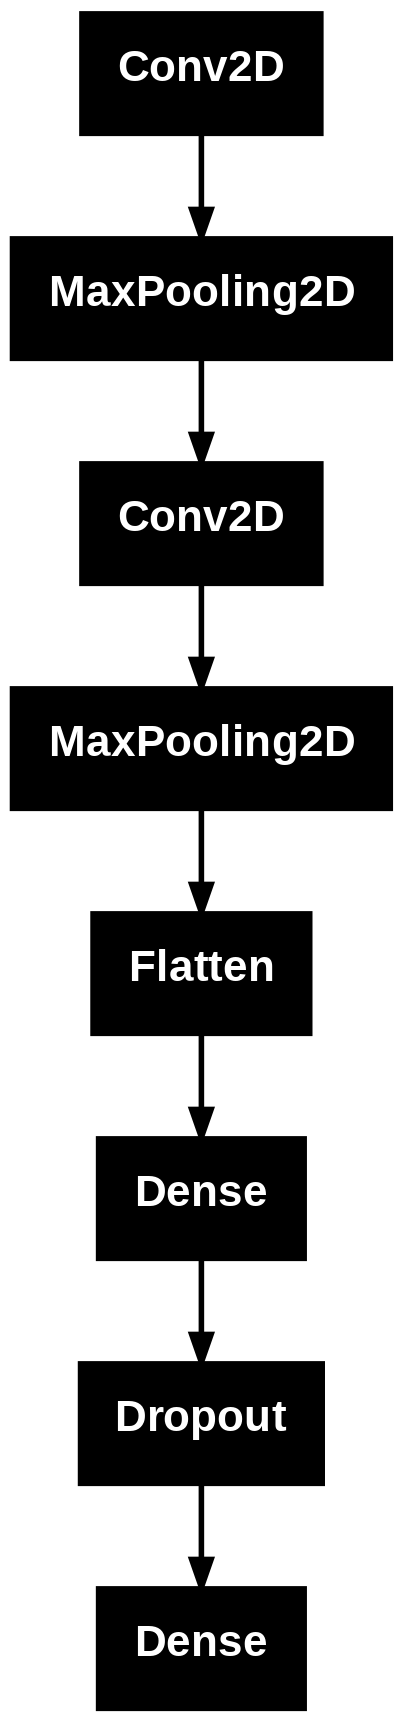

In [ ]:
keras.utils.plot_model(model)

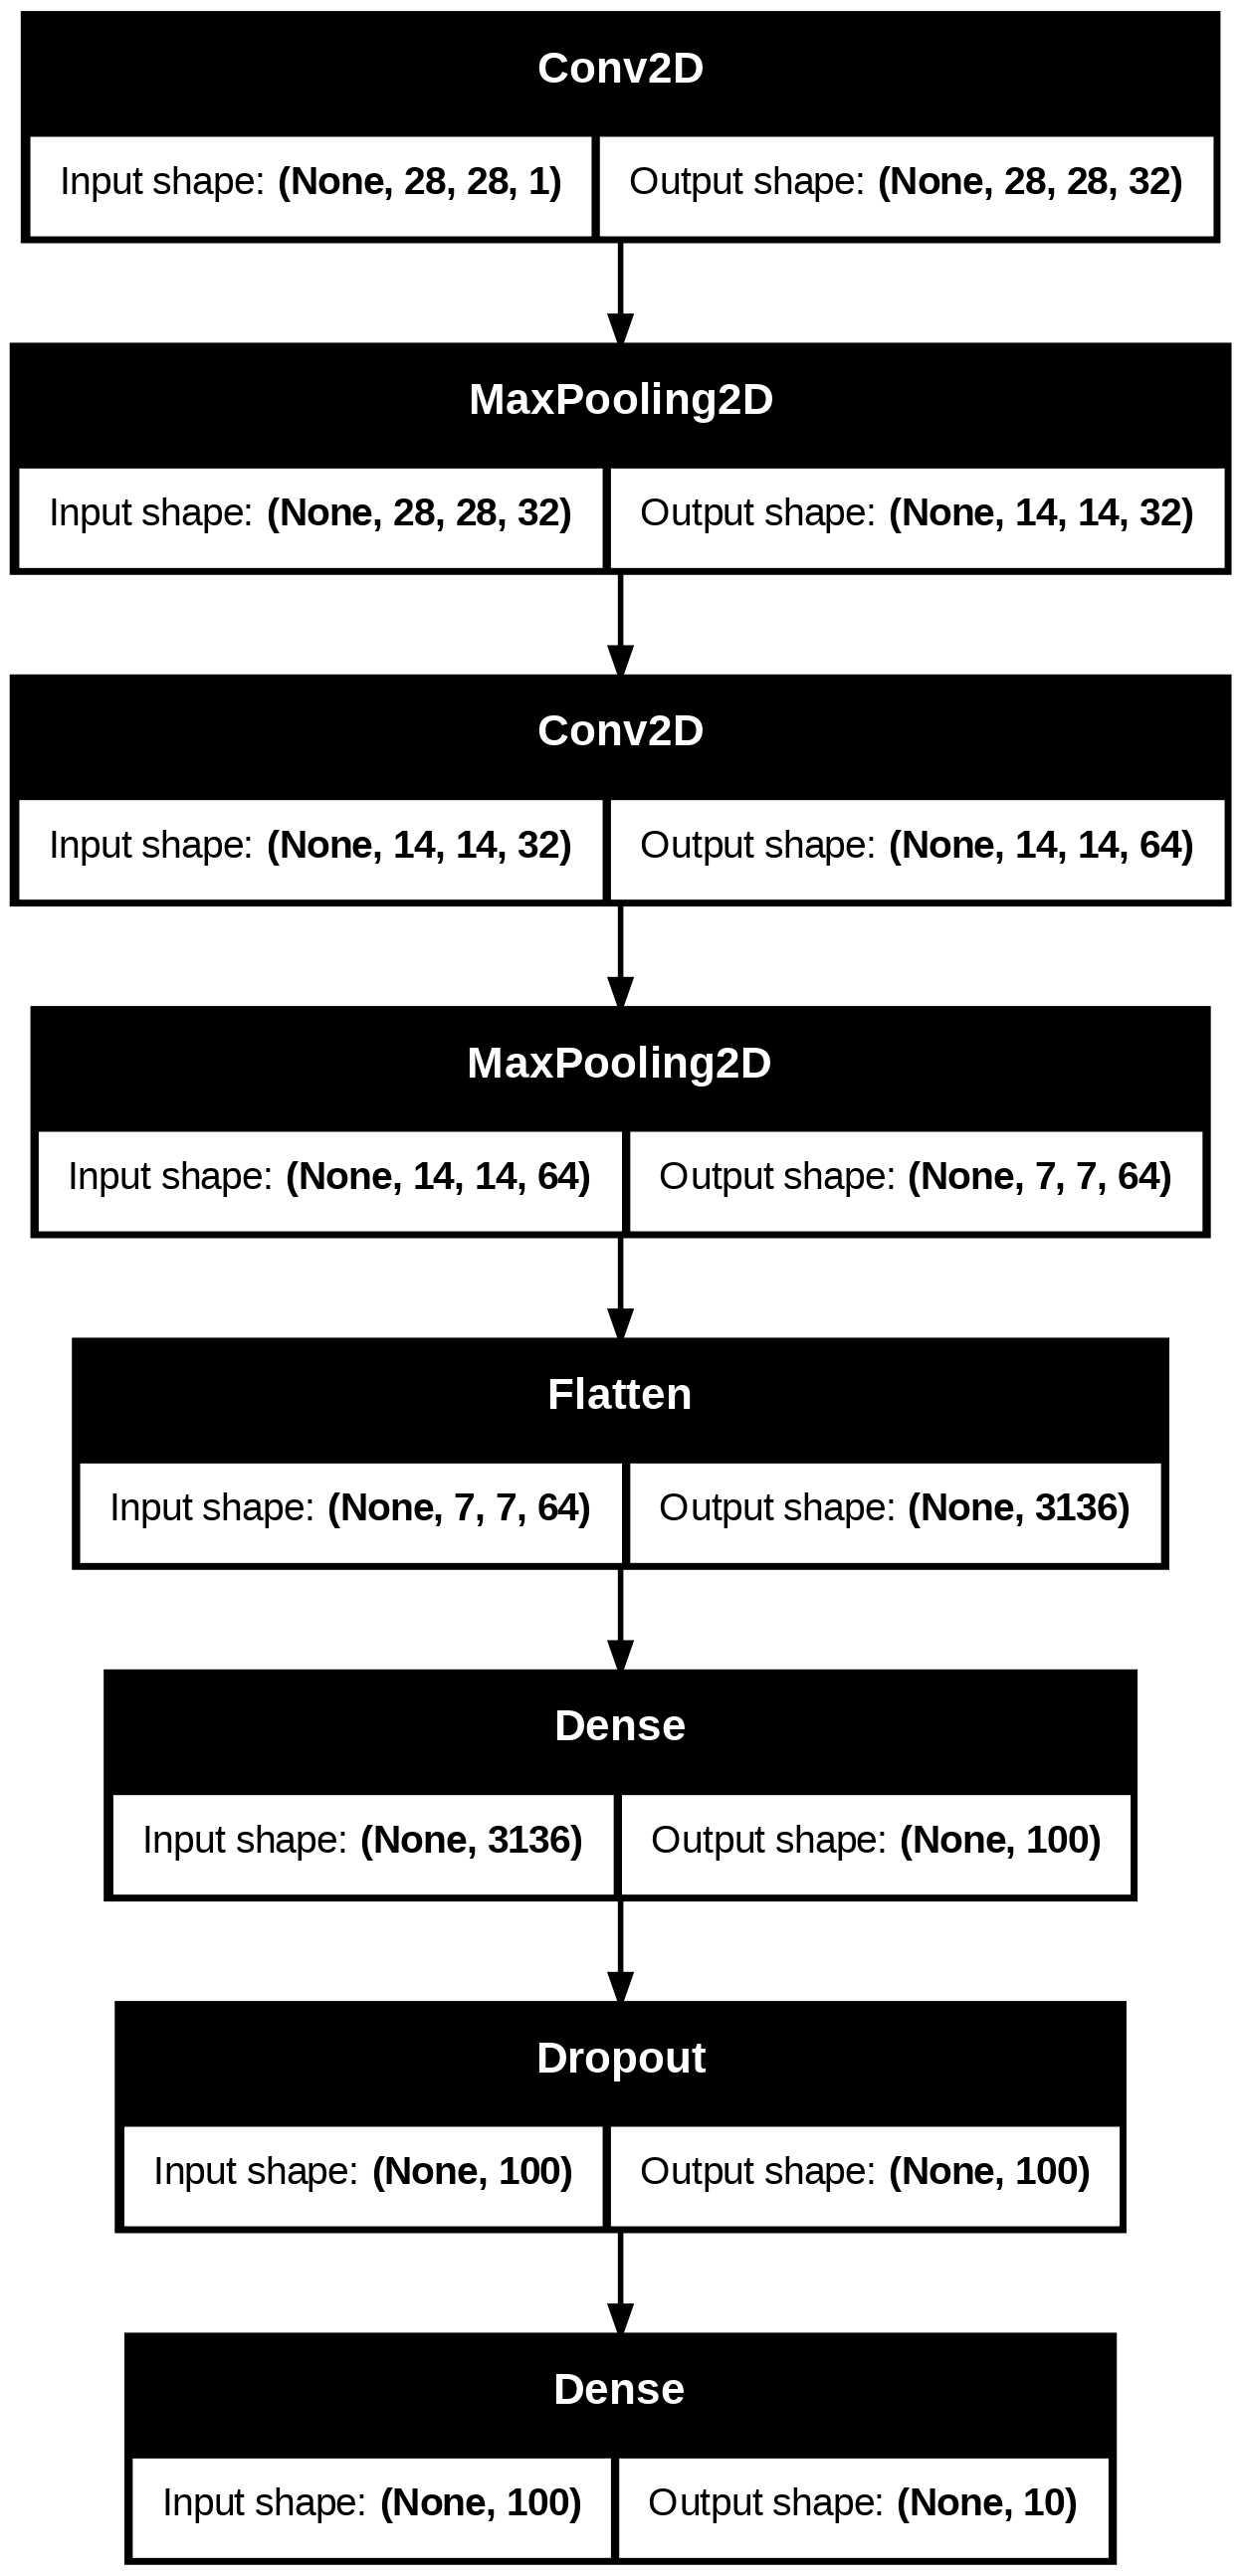

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7465 - loss: 0.7058 - val_accuracy: 0.8827 - val_loss: 0.3220
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8707 - loss: 0.3558 - val_accuracy: 0.8934 - val_loss: 0.2818
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8901 - loss: 0.2996 - val_accuracy: 0.9071 - val_loss: 0.2509
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9023 - loss: 0.2659 - val_accuracy: 0.9123 - val_loss: 0.2432
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9098 - loss: 0.2437 - val_accuracy: 0.9144 - val_loss: 0.2315
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9171 - loss: 0.2201 - val_accuracy: 0.9167 - val_loss: 0.2298
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9238 - loss: 0.2030 - val_accuracy: 0.9165 - val_loss: 0.2342
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9293 - loss: 0.1881 

In [ ]:
import matplotlib.pyplot as plt

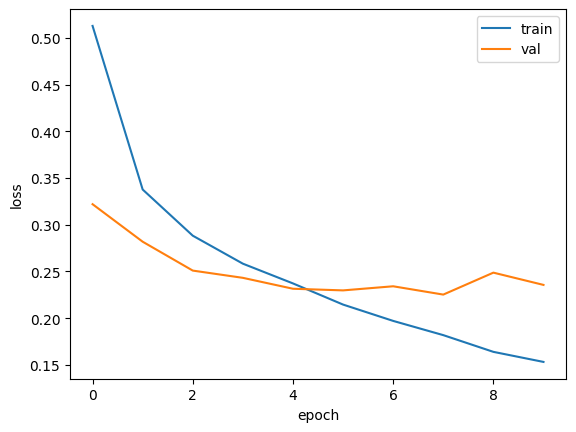

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9213 - loss: 0.2160


[0.225275456905365, 0.9206666946411133]

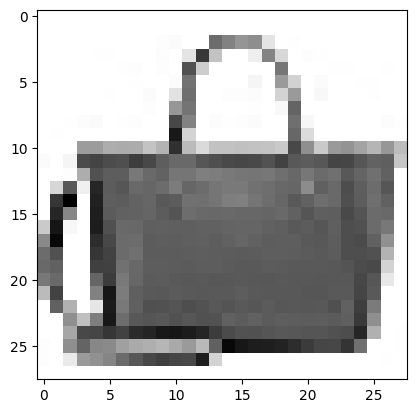

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
[[4.4770494e-19 9.3211822e-28 1.6310435e-22 1.8716438e-20 2.1713354e-20
  1.6487611e-20 3.1606589e-21 1.3134407e-18 1.0000000e+00 1.1225654e-21]]


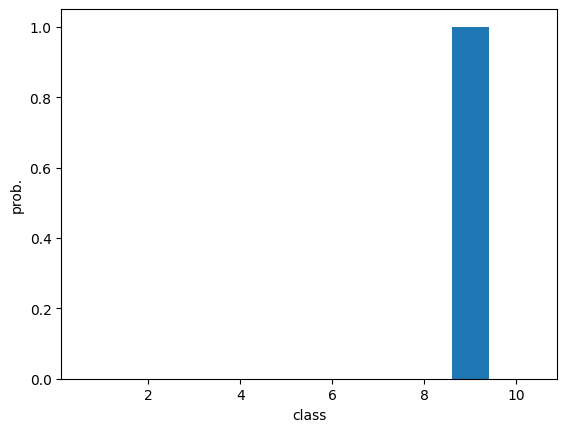

In [ ]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9134 - loss: 0.2695


[0.2570801079273224, 0.914900004863739]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


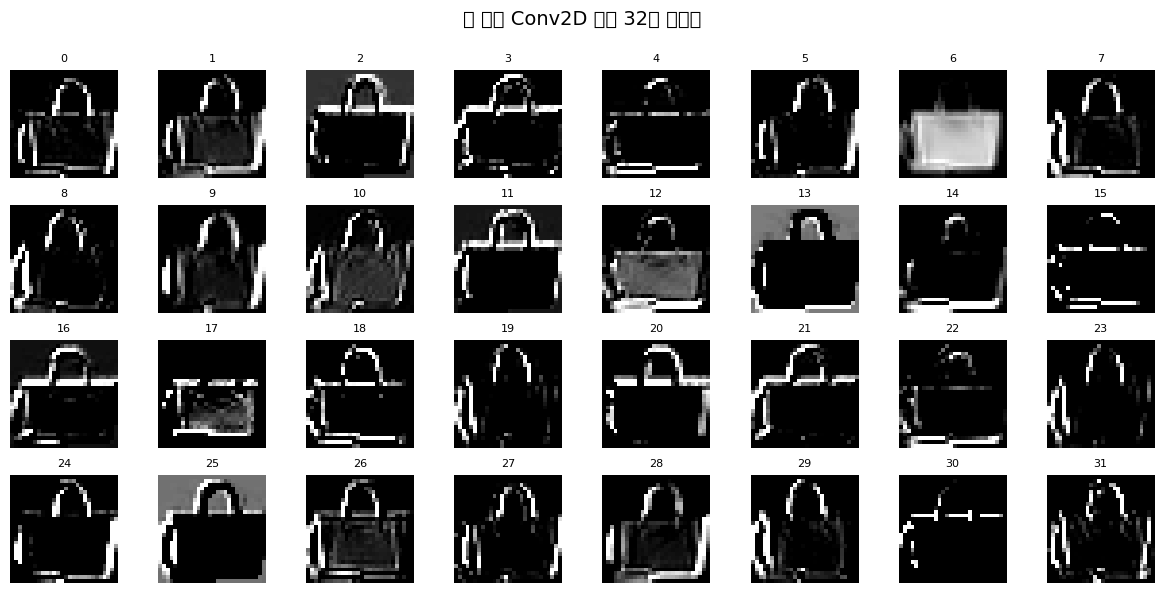

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models

# (중요) 모델 한 번 호출
_ = model.predict(val_scaled[:1])

# Conv 레이어 출력 추출 모델 만들기
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

# 예측할 입력 샘플
img = val_scaled[0].reshape(1, 28, 28, 1)

# 첫 번째 Conv 레이어의 출력
feature_maps = activation_model.predict(img)
first_layer_activation = feature_maps[0]  # 첫 번째 Conv 레이어의 출력 (형태: (1, 28, 28, 32))

# 개별 특성맵 그리기
n_features = first_layer_activation.shape[-1]  # 32
size = first_layer_activation.shape[1]         # 28

plt.figure(figsize=(12, 6))
for i in range(n_features):
    ax = plt.subplot(4, 8, i + 1)
    feature_img = first_layer_activation[0, :, :, i]

    # 정규화
    feature_img -= feature_img.mean()
    feature_img /= (feature_img.std() + 1e-5)
    feature_img *= 64
    feature_img += 128
    feature_img = np.clip(feature_img, 0, 255).astype('uint8')

    # plt.imshow(feature_img, cmap='viridis')
    plt.imshow(feature_img, cmap='gray')
    plt.axis('off')
    plt.title(f'{i}', fontsize=8)

plt.tight_layout()
plt.suptitle("첫 번째 Conv2D 층의 32개 특성맵", fontsize=14)
plt.subplots_adjust(top=0.88)
plt.show()

가중치 shape: (3, 3, 1, 32)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


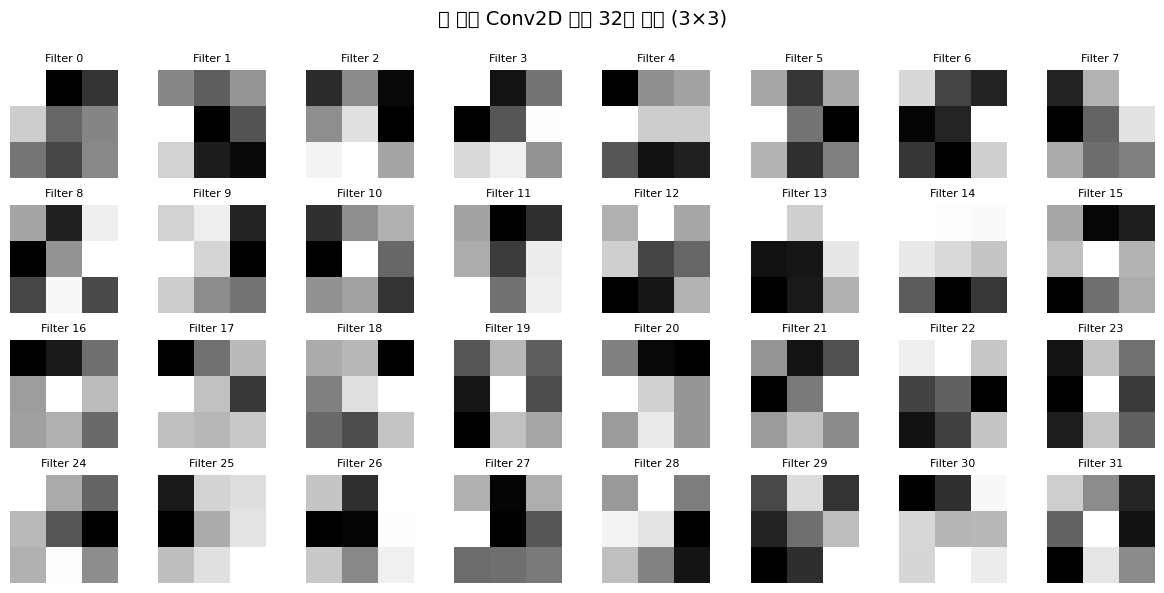

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# 첫 번째 Conv2D 레이어 가져오기
conv1 = model.layers[0]
weights, biases = conv1.get_weights()  # weights: (3, 3, 1, 32)

print("가중치 shape:", weights.shape)

# 3x3 필터가 32개 (입력 채널이 1이므로 시각화 간단)
plt.figure(figsize=(12, 6))
for i in range(32):
    f = weights[:, :, 0, i]  # i번째 필터 (3, 3)

    # 정규화
    f_min, f_max = f.min(), f.max()
    f = (f - f_min) / (f_max - f_min + 1e-5)  # 0~1로 정규화

    plt.subplot(4, 8, i + 1)
    plt.imshow(f, cmap='gray')
    plt.axis('off')
    plt.title(f'Filter {i}', fontsize=8)

plt.tight_layout()
plt.suptitle("첫 번째 Conv2D 층의 32개 커널 (3×3)", fontsize=14)
plt.subplots_adjust(top=0.88)
plt.show()
